# NOTE: This part was done by Katie, outputs arehere: 
/lab/solexa_weissman/kyost/pe_lineage/230427_4T1_10X/merfish_4T1_genes_KEY_150set.csv
/lab/solexa_weissman/kyost/pe_lineage/230427_4T1_10X/merfish_4T1_genes_KEY_394set.csv

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import scanpy as sc
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, 
                              frameon=False, figsize=(4, 4), 
                              fontsize=8, facecolor='white')

In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")

# Define the output files
library_folder = os.path.join(library_master_folder, '4T1_MERFISH', 'MF4_4T1Primary16bit')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")

- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes
- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit


## Load processed h5ad data

In [3]:
sequencing_data_folder = r'/lab/solexa_weissman/kyost/pe_lineage/230427_4T1_10X'
# Old file: #'F112_F122_filterCells_finalLabels.h5ad'
sequencing_data_filename = os.path.join(sequencing_data_folder, r'F112_F122_filterCells_finalLabels.h5ad')
# load 
seq_adata = sc.read_h5ad(sequencing_data_filename)

In [4]:
seq_adata

AnnData object with n_obs × n_vars = 34141 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8', 'seurat_clusters', 'pANN', 'DF.classifications_1', 'DF.classifications_2', 'percent.mt', 'DF.classifications', 'SingleR_labels', 'RNA_snn_res.0.3', 'RNA_snn_res.0.2', 'RNA_snn_res.0.1', 'RNA_snn_res.0.15', 'RNA_snn_res.0.17', 'RNA_snn_res.0.18', 'RNA_snn_res.0.25', 'Level2_ident', 'Level1_ident', 'AllCells_ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [5]:
# update Level2_ident, its bugged in the h5ad file
label_filename = os.path.join(sequencing_data_folder, 'F112_F122_filterCells_finalLabels_metadata.txt')
label_df = pd.read_table(label_filename)
index_to_label = {_i:_r['Level2_ident'] for _i, _r in label_df.iterrows()}
# overwrite on the .obs['Level2_ident']
updated_labels = [index_to_label[_i] for _i in seq_adata.obs.index]
seq_adata.obs['Level2_ident'] = updated_labels

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


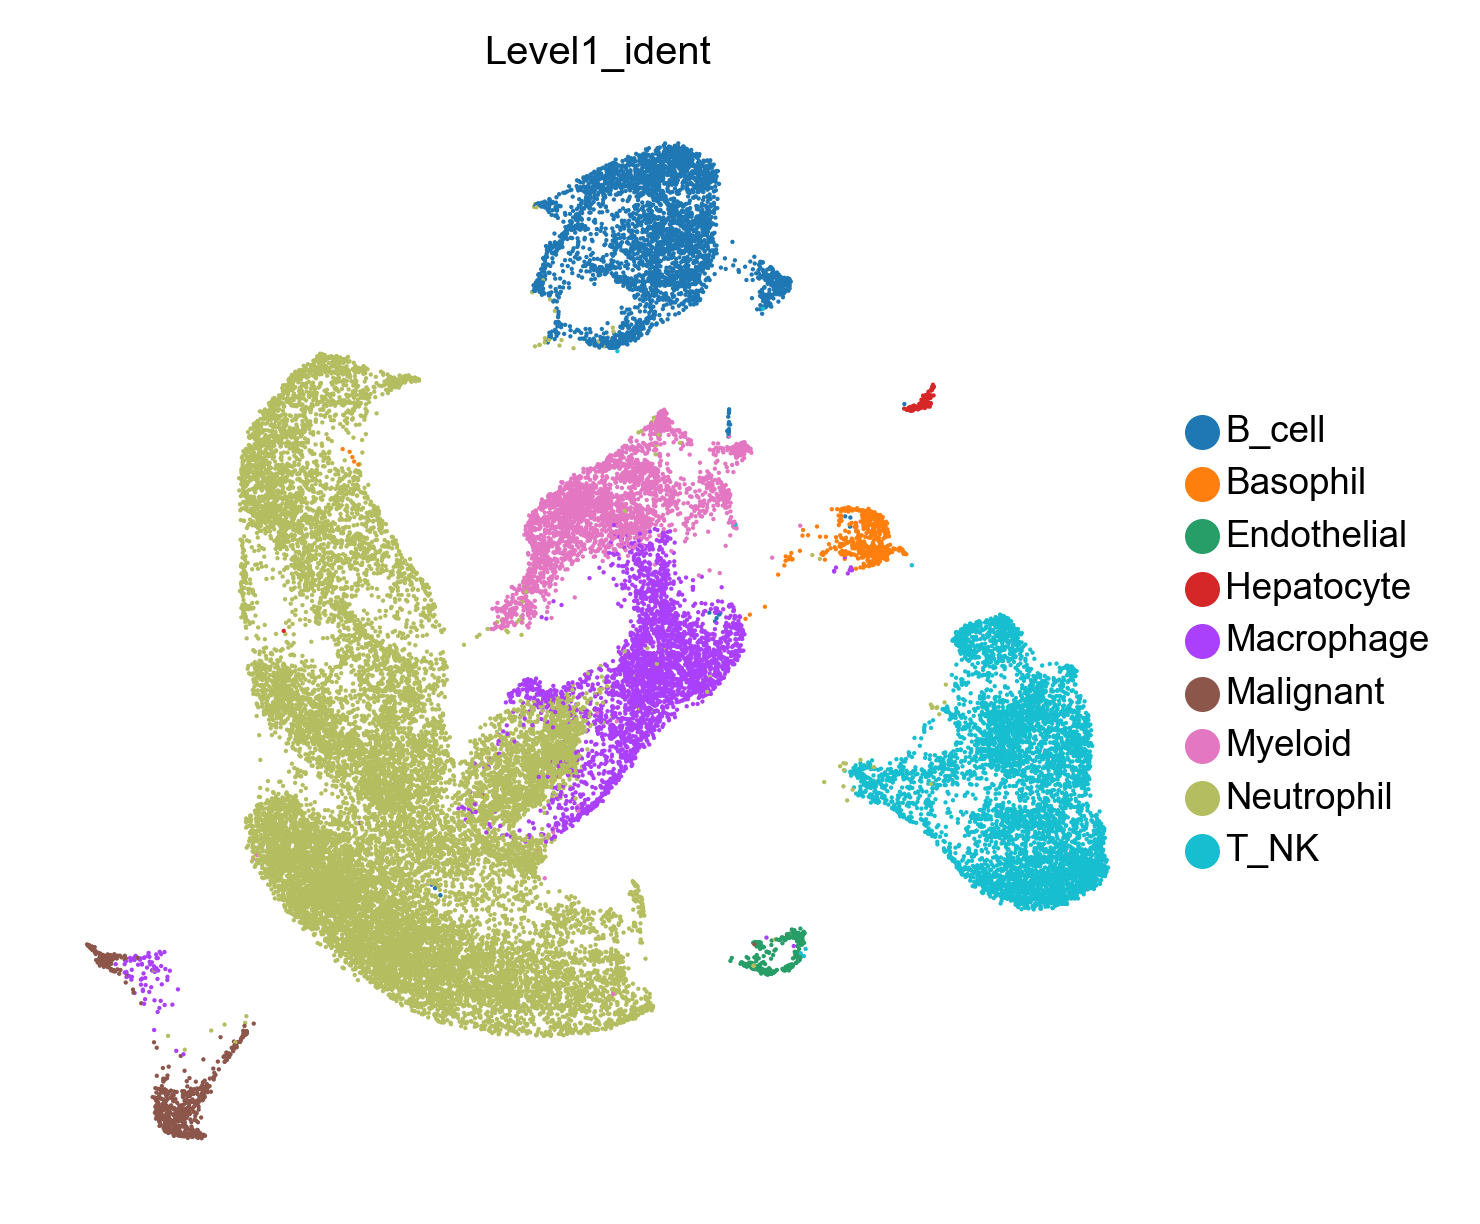

In [6]:
lev1_umap = sc.pl.umap(seq_adata, color='Level1_ident', s=3)

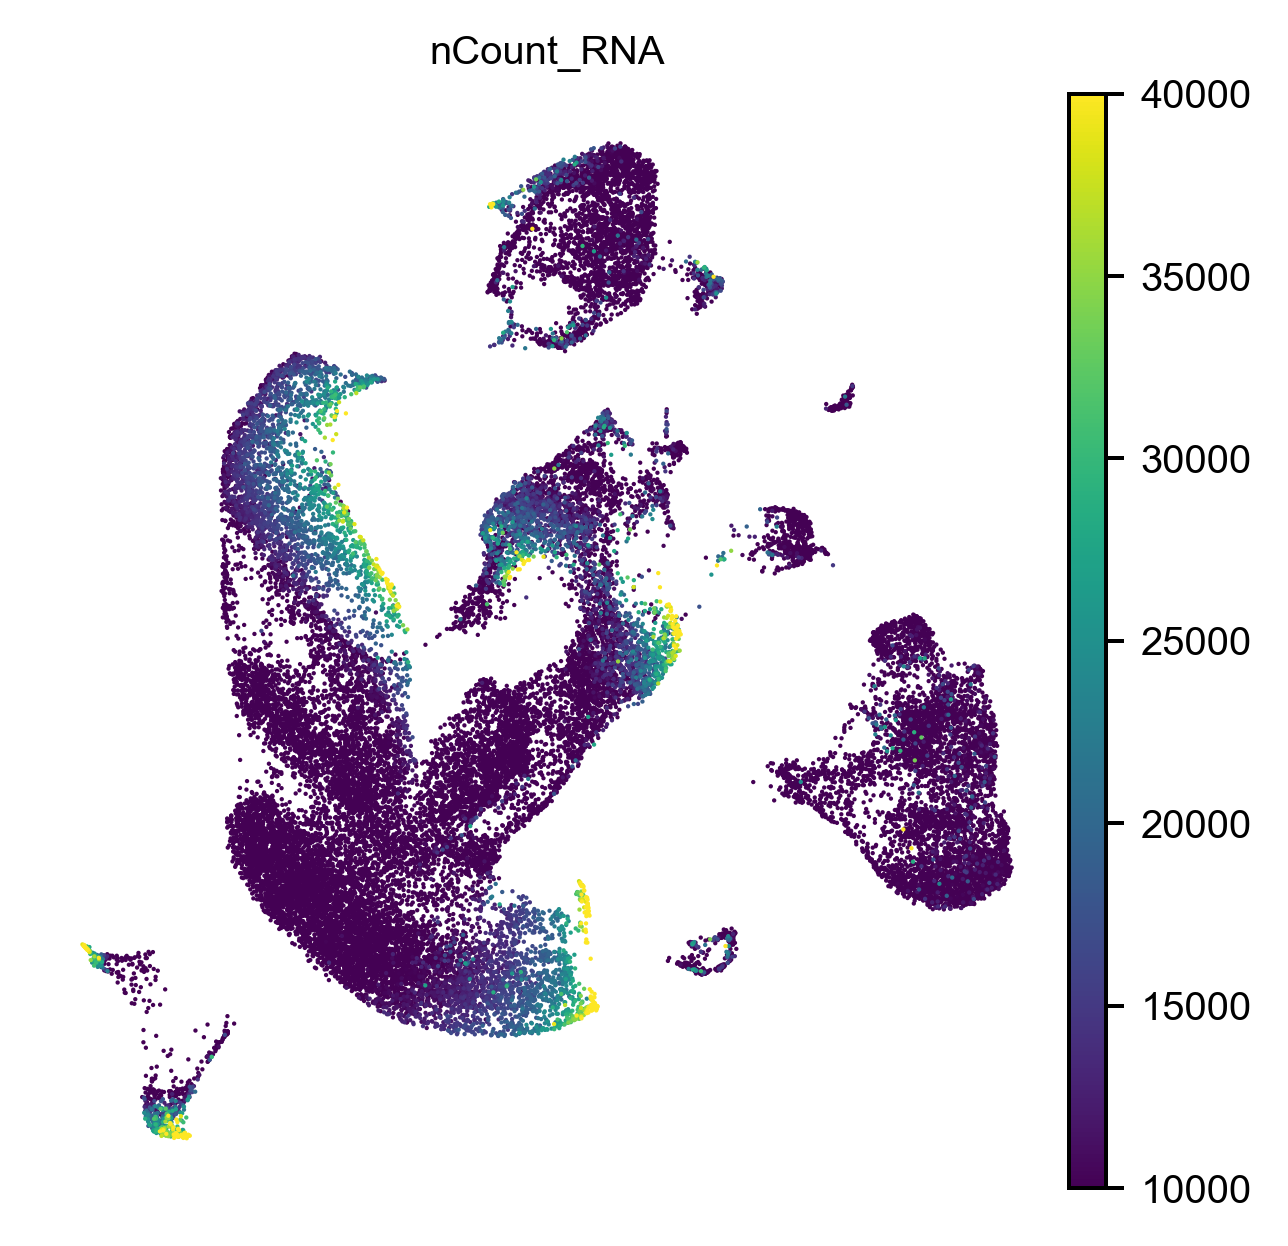

In [7]:
nt_umap = sc.pl.umap(seq_adata, color='nCount_RNA', s=3, vmax=4e4, vmin=1e4)

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


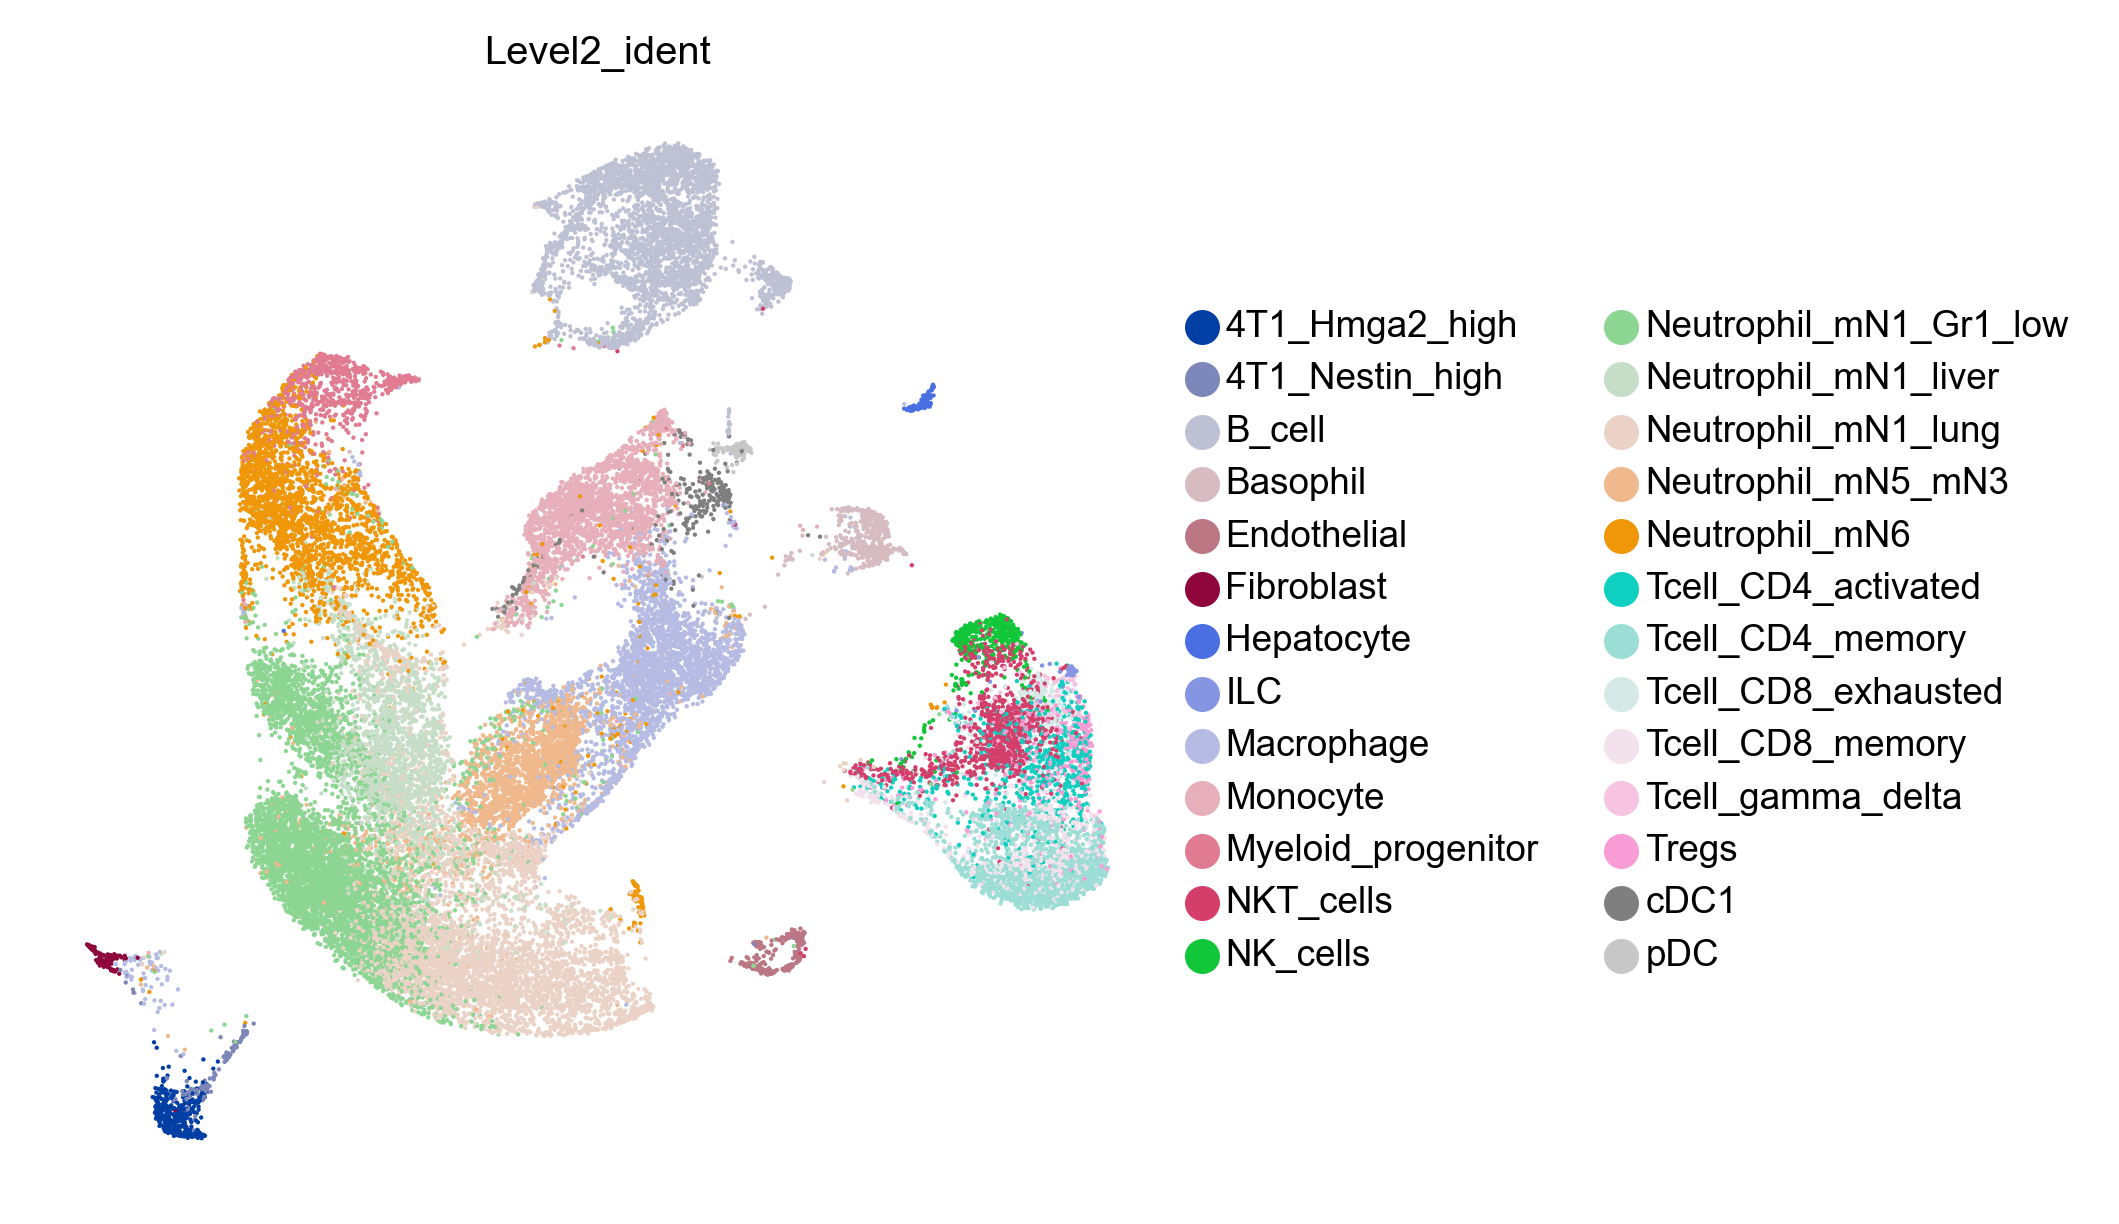

In [8]:
nt_umap = sc.pl.umap(seq_adata, color='Level2_ident', s=3, vmin=0)

# Directly load filtered genes

A curated list from Katie

In [11]:
filtered_gene_filename = r'/lab/solexa_weissman/kyost/pe_lineage/230427_4T1_10X/merfish_4T1_genes_KEY_150set.csv'
filtered_gene_df = pd.read_csv(filtered_gene_filename)
marker_genes = list(filtered_gene_df['0'].values)

# Select adata

In [12]:
# Calculate the mean counts
filtered_adata = seq_adata.copy()
sc.pp.calculate_qc_metrics(filtered_adata, percent_top=None, log1p=False, inplace=True, use_raw=True)

In [13]:
filtered_save_filename = os.path.join(os.path.join(library_folder, 'filtered.h5ad'))

overwrite = True

if not os.path.exists(filtered_save_filename) or overwrite:
    print(f"save adata into file: {filtered_save_filename}")
    filtered_adata.write(filtered_save_filename)
else:
    print(f"savefile: {filtered_save_filename} already exists")

save adata into file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/filtered.h5ad


## Select marker genes

In [34]:
label_key = 'Level1_ident'

In [15]:
# Select the marker genes
sel_adata = filtered_adata[:, filtered_adata.var.index.isin(marker_genes)]

In [16]:
marker_genes = np.array(list(marker_genes))

## Redo UMAP of selected genes

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


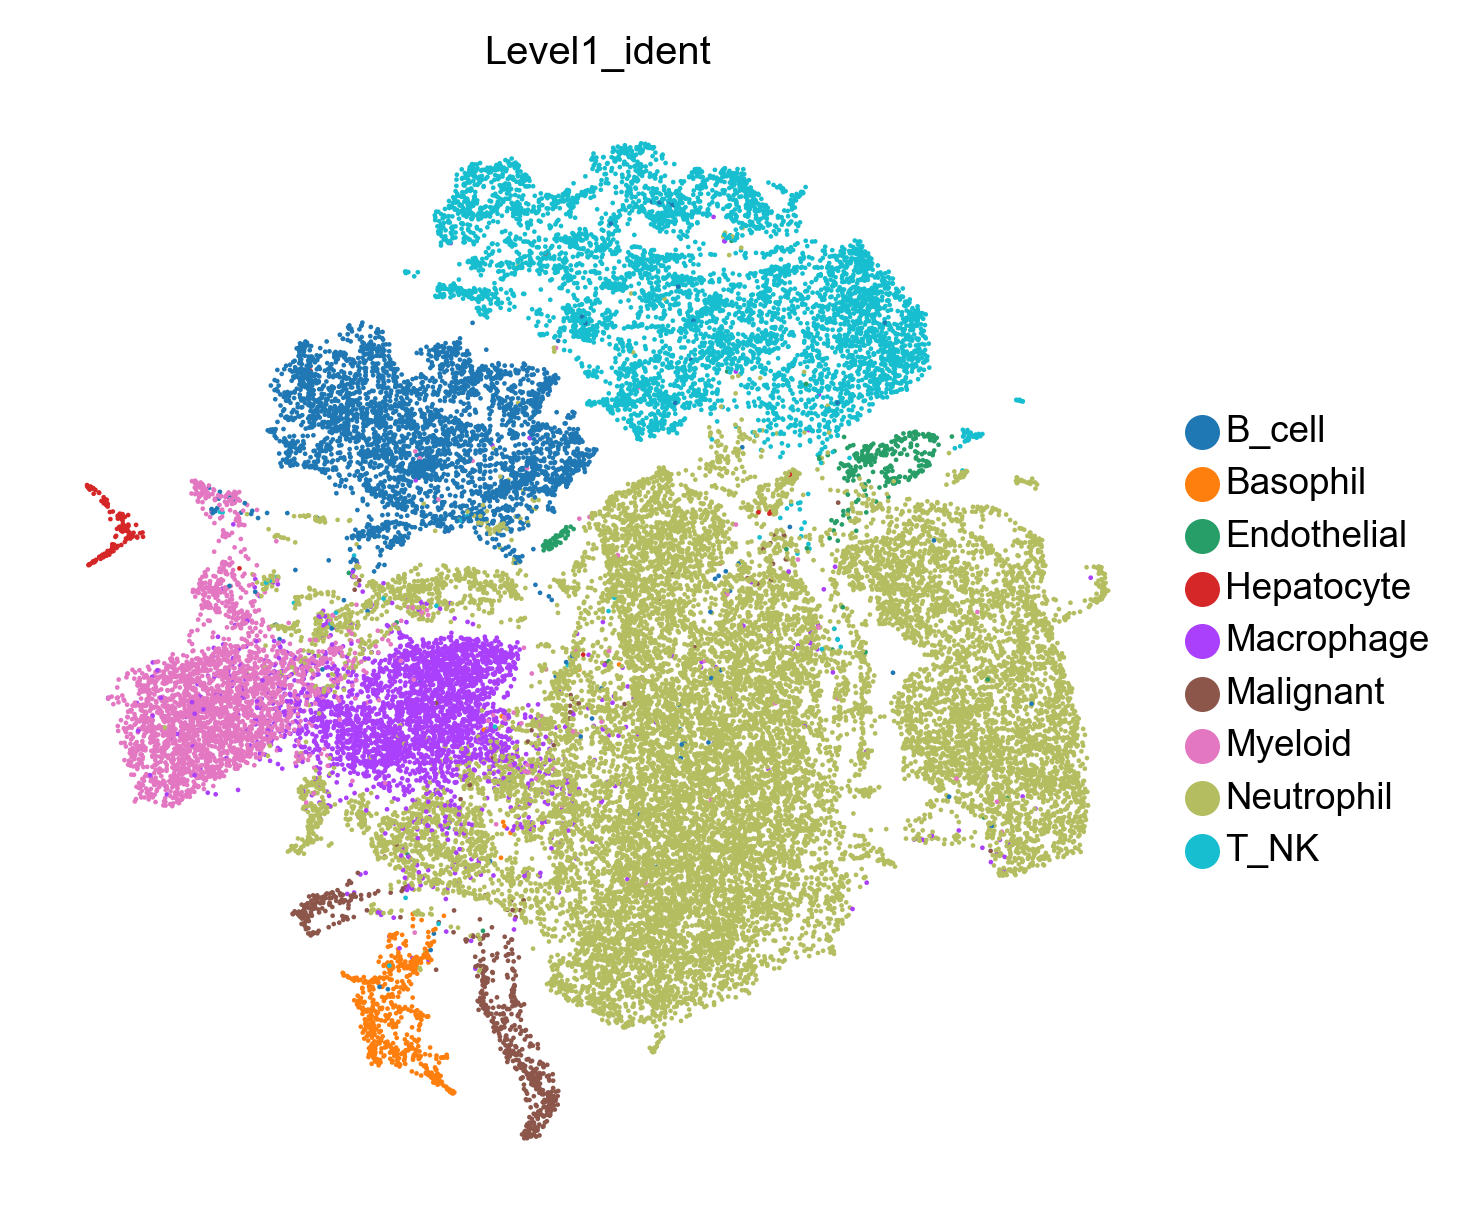

CPU times: user 1min 33s, sys: 14.2 s, total: 1min 47s
Wall time: 39 s


In [17]:
%%time
# Validate that the selected genes recapitulate the cluster structures
adata_selected = filtered_adata[:, filtered_adata.var.index.isin(marker_genes)]
# Principal component analysis
sc.tl.pca(adata_selected, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(adata_selected, n_neighbors=5, n_pcs=30)
# Embed with UMAP
sc.tl.umap(adata_selected)
# Plot the clusters
sc.pl.umap(adata_selected, color='Level1_ident')
# Interestingly, the selected genes also removed the batch effect


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


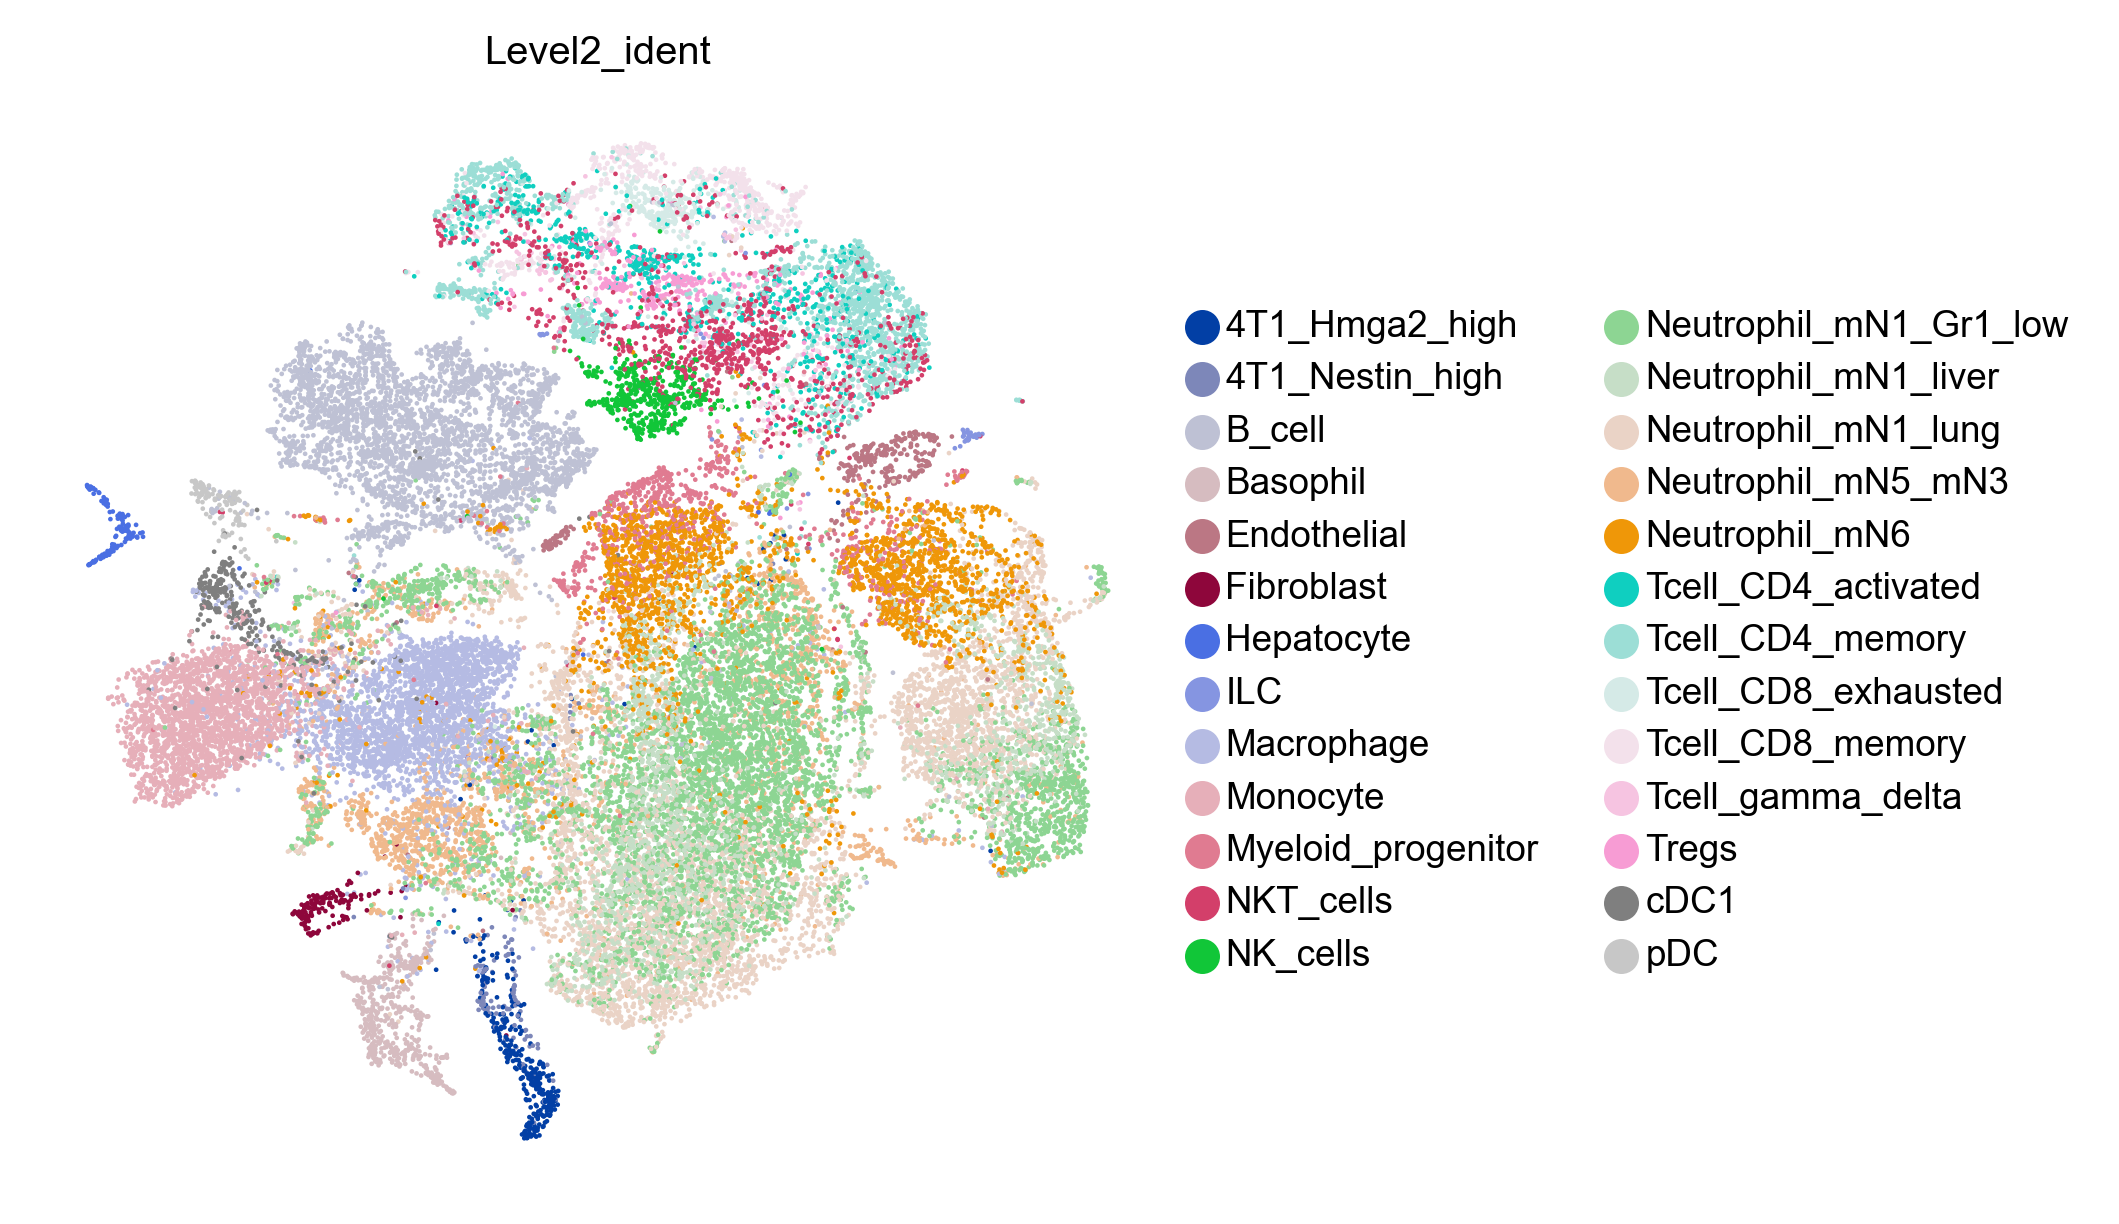

In [18]:
sc.pl.umap(adata_selected, color='Level2_ident')


# Check gene expression in each type

In [36]:
# cell type specific expression
CellTypeMeanExp = pd.DataFrame()
for cell_type in adata_selected.obs[label_key].value_counts().index:
    if cell_type == '':
        continue
    _type_adata = filtered_adata[filtered_adata.obs[label_key] == cell_type]
    sc.pp.calculate_qc_metrics(_type_adata, percent_top=None, log1p=False, inplace=True, use_raw=True)
    print(cell_type)
    # save mean
    CellTypeMeanExp[cell_type] = _type_adata.var['mean_counts']
    #break

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


Neutrophil


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


T_NK


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


B_cell


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


Macrophage


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


Myeloid
Malignant


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


Basophil
Endothelial
Hepatocyte


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [37]:
CellTypeMeanExp.loc[marker_genes]

Neutrophil      T_NK    B_cell  Macrophage   Myeloid  \
Mat1a            0.006605  0.005849  0.012248    0.001223  0.007635   
Fxyd3            0.000448  0.000479  0.000339    0.003693  0.000181   
Pglyrp1          2.241849  0.257465  0.400375    0.412732  0.396545   
Col5a2           0.001847  0.000647  0.000315    0.022656  0.001988   
Ankrd1           0.000355  0.000000  0.000000    0.003569  0.000000   
...                   ...       ...       ...         ...       ...   
Gpihbp1          0.001301  0.001733  0.001773    0.002506  0.002252   
Ldb2             0.004991  0.002660  0.001737    0.004938  0.001407   
A230098N10Rik    0.000048  0.000000  0.000000    0.000751  0.000373   
Itgax            0.040839  0.026849  0.007493    0.248418  0.122759   
Cyp2j5           0.000028  0.000434  0.000000    0.000000  0.000000   

               Malignant  Basophil  Endothelial  Hepatocyte  
Mat1a           0.000000  0.007202     0.011843    3.412124  
Fxyd3           0.317595  0.002714     0.000000    0.014720  
Pglyrp1         0.136838  1.388802     0.618496    0.567325  
Col5a2          0.380403  0.000000     0.185649    0.000000  
Ankrd1          0.231825  0.001915     0.000000    0.000000  
...                  ...       ...          ...         ...  
Gpihbp1         0.000000  0.002759     1.245850    0.000000  
Ldb2            0.007588  0.001624     1.827753    0.000000  
A230098N10Rik   0.000979  0.281805     0.004220    0.000000  
Itgax           0.005268  0.015563     0.023521    0.024267  
Cyp2j5          0.000000  0.001978     0.000000    0.343381  

[150 rows x 9 columns]

In [38]:
CellTypeUmiFrac = CellTypeMeanExp.copy()
for cell_type in CellTypeUmiFrac.columns:
    CellTypeUmiFrac[cell_type] = CellTypeUmiFrac[cell_type] / np.sum(CellTypeUmiFrac[cell_type])

In [39]:
CellTypeUmiFrac.loc[marker_genes].values.sum(0)

array([0.00829003, 0.00983518, 0.00834438, 0.0098121 , 0.00670956,
       0.00411561, 0.0124393 , 0.01004105, 0.01532591])

## Filter marker genes

In [40]:
# remove gene with very high umi
gene_to_remove = []
soft_celltype_th = 2
hard_xs, hard_ys = np.where(CellTypeUmiFrac > 0.008)
soft_xs, soft_ys = np.where(CellTypeUmiFrac > 0.004)

for _ix, _iy in zip(hard_xs, hard_ys):
    _gene = CellTypeUmiFrac.index[_ix]
    _type = CellTypeUmiFrac.columns[_iy]
    if _gene not in gene_to_remove:
        print(f"hard remove: {_gene}")
        gene_to_remove.append(_gene)
print(f"hard remove: {gene_to_remove}")
# soft
for _ix, _iy in zip(soft_xs, soft_ys):
    _gene = CellTypeUmiFrac.index[_ix]
    _type = CellTypeUmiFrac.columns[_iy]
    
    if _gene not in gene_to_remove and np.sum(soft_xs==_ix) >= soft_celltype_th:
        print(f"soft remove: {_gene}")
        gene_to_remove.append(_gene)
print(f"soft remove: {gene_to_remove}")

hard remove: []
soft remove: []


In [41]:
kept_marker_genes = np.array([_g for _g in marker_genes if _g not in gene_to_remove])

# save

In [42]:
library_folder

'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit'

In [43]:
target_gene_mean_exp_df = CellTypeMeanExp.loc[kept_marker_genes]
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# save
print(f"saving mean_exp for target genes: {target_gene_mean_exp_filename}")
target_gene_mean_exp_df.to_csv(target_gene_mean_exp_filename)

saving mean_exp for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/marker_gene_mean_exp.csv


In [44]:
target_gene_umi_frac_df = CellTypeUmiFrac.loc[kept_marker_genes]
target_gene_umi_frac_filename = os.path.join(library_folder, 'marker_gene_umi_frac.csv')
# save
print(f"saving umi_frac for target genes: {target_gene_umi_frac_filename}")
target_gene_umi_frac_df.to_csv(target_gene_umi_frac_filename)

saving umi_frac for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/marker_gene_umi_frac.csv


In [45]:
celltype_num = filtered_adata.obs[label_key].value_counts()

celltype_num_filename = os.path.join(library_folder, 'celltype_num.csv')
celltype_num.to_csv(celltype_num_filename)

In [46]:
label_key

'Level1_ident'

In [49]:
# adata
selected_save_filename = os.path.join(os.path.join(library_folder, 'selected_marker_gene_adata.h5ad'))
print(selected_save_filename)
adata_selected.write(selected_save_filename)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/selected_marker_gene_adata.h5ad
